# 簡述

通過無母數(非參數)法對生存數據進行初步分析之後，可以對接下來的生存數據建模過程提供有參考價值的背景信息。

[參考資料](https://bookdown.org/ccwang/medical_statistics6/nonparametric.html)

## Kaplan-Meier 生存曲線

Kaplan-Meier 生存曲線（Kaplan-Meier survival curve）是一種用來估計時間至特定事件發生（例如生存時間或失敗時間）的機率分佈的統計方法。它通常用於生存分析中，該分析專注於研究事件發生的時間以及影響事件發生時間的因素。

KM圖的 y 為生存機率 $S(t) = P(T>t)$, 已知在時間點 0 時生存機率 = 1, 所以由直覺可以推論得出 : 假設 $t_i$ 為事件發生時間點且 $h_i$ 為相對應的風險率, 

則 $S(t_j) = \prod^j_{k=1}(1-h_k)$. 即經過 $t_{j-1}$ 還存活且在 $t_j$ 未發生事件的機率.

其中, $h_j = \frac{d_j}{n_j}$, $d_j$ 為發生事件人數; $n_j$ 為該時間點的觀察人數. 註:因為是觀察人數, 所以若有設限資料消失則 $n_j$ 也會減少.

### 例子

In [43]:
import pandas as pd

data = pd.read_csv('data1.csv')
data.head()

,ID,Survivaltime,Status,group
0,A,12,0,1
1,B,8,0,1
2,C,12,0,2
3,D,7,1,1
4,E,5,0,2


In [38]:
data1 = data[data['group'] == 1]
data2 = data[data['group'] == 2]

data1 = data1.sort_values(by = ['Survivaltime', 'Status'], ascending=[True, False]) # 若有時間點相同的, 則依照狀態排序(先完備資料再設限資料)
data2 = data2.sort_values(by = ['Survivaltime', 'Status'], ascending=[True, False]) # 通常時間點相同則會合併成一個row, 不過這個數據沒有, 我也不特別合併了
ST_list = [[], []]
run = -1
for run_data in [data1, data2]:
    run += 1
    ST = 1
    sample_num = len(run_data)
    for i in range(sample_num):
        if run_data['Status'].values[i] > 0 :
            ST *= 1 - run_data['Status'].values[i]/sample_num
            ST_list[run].append(ST)
            sample_num -= run_data['Status'].values[i]
        else:
            sample_num -= 1 # 因為每個時間點只有一個人, 若設限資料有很多人則要減少很多人
            ST_list[run].append('-')

data1['ST'] = ST_list[0]
data2['ST'] = ST_list[1]

print('group 1')
print(data1)
print('group 2')
print(data2)

group 1
   ID  Survivaltime  Status  group   ST
13  N             4       0      1    -
11  L             6       0      1    -
3   D             7       1      1  0.8
1   B             8       0      1    -
12  M             9       0      1    -
0   A            12       0      1    -
5   F            12       0      1    -
group 2
   ID  Survivaltime  Status  group        ST
9   J             1       1      2  0.857143
8   I             4       1      2  0.714286
4   E             5       0      2         -
6   G             6       1      2  0.535714
10  K             7       1      2  0.357143
7   H            12       1      2  0.178571
2   C            12       0      2         -


### KaplanMeierFitter

KaplanMeierFitter 函數是 lifelines 套件中的主要功能之一，它用於創建 Kaplan-Meier 生存曲線。

其功能如下 :

* median_survival_time_ 屬性：用於計算估計的中位生存時間。
* confidence_interval_ 屬性：用於計算估計的生存曲線的信賴區間。
* survival_function_ 方法：用於獲取估計的生存函數，您可以使用它來獲取生存曲線的數據。
* plot() 方法：用於繪製 Kaplan-Meier 生存曲線圖。
* percentile() 方法：用於計算指定百分位數的生存時間。

In [67]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(data2['Survivaltime'], event_observed = data2['Status'])
print(kmf.survival_function_)
#print(kmf.percentile(0.5))

          KM_estimate
timeline             
0.0          1.000000
1.0          0.857143
4.0          0.714286
5.0          0.714286
6.0          0.535714
7.0          0.357143
12.0         0.178571


#### 繪製圖形

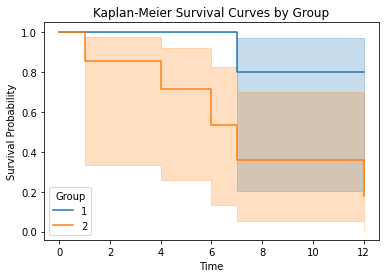

In [53]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 創建 Kaplan-Meier 生存分析對象
kmf = KaplanMeierFitter()

# 按照 'group' 列拆分數據並計算 Kaplan-Meier 曲線
groups = data['group'].unique()
for group in groups:
    group_data = data[data['group'] == group]
    kmf.fit(group_data['Survivaltime'], event_observed=group_data['Status'], label=group)
    kmf.plot()


plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves by Group')
plt.legend(title='Group')
plt.show()


## 生命表 (life table)

在 KM 中, 觀察對象的時間點是間段的, 而生命表是一個區間(例如1~2年的事件人數和設限人數).

和 KM 不同的是, 生命表計算生存機率時, 並非直接不考慮設限資料, 而是先把觀察人數扣掉設限資料的1/2. 理由是 KM 能確定設限資料有活到該時間點, 但生命表無法確定設限資料在那個區間的狀態.

所以公式變為 : $S(t) = \prod^j_{k=1}(1-p_k)~~ for ~~ t_j \leq t < t_{j+1}$, 其中 $p_j = \frac{d_j}{n_j - m_j/2}$, $m_j$ 為時間點 $t$ 時的設限資料數量.

<font size = 4 color = orange> 注意 : 雖然表格顯示0~1是某個生存率, 但是實際上繪製圖形時生存機率改變點是在結束的時間(也就是0~1的1)</font>

In [77]:
import pandas as pd
import numpy as np 
data = pd.read_csv('data2.csv')
ST = 1
ST_list = []
P = []
for i in range(len(data)):
    pi = data['deaths'].values[i] / (data['n'].values[i] - data['cencoring'].values[i]/2)
    P.append(pi)
    ST *= 1 - pi
    ST_list.append(ST)

data['P'] = P
data['1-P'] = 1-np.array(P)
data['ST'] = ST_list
data

,year,n,deaths,cencoring,P,1-P,ST
0,0~1,2418,456,0,0.188586,0.811414,0.811414
1,1~2,1962,226,39,0.116345,0.883655,0.717010
2,2~3,1697,152,22,0.090154,0.909846,0.652369
3,3~4,1523,171,23,0.113133,0.886867,0.578565
4,4~5,1329,135,24,0.102506,0.897494,0.519259
5,5~6,1170,125,107,0.111957,0.888043,0.461124
6,6~7,938,83,133,0.095238,0.904762,0.417207
7,7~8,722,74,102,0.110283,0.889717,0.371196
8,8~9,546,51,68,0.099609,0.900391,0.334222
9,9~10,427,42,64,0.106329,0.893671,0.298684


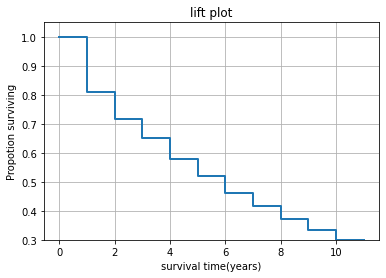

In [123]:
import matplotlib.pyplot as plt

data_day = data['year'].str.split('~', expand=True).values.ravel().tolist() #切割資料後, expand=T是分成兩col, 然後在把2*10資料轉成1*20, 之後轉成list
data_day = [0, 1] + [int(value)+1 for value in data_day]
data_ST = [1, 1] + data[['ST','ST']].values.ravel().tolist()

# 使用 step 函數繪製樓梯下降的圖形
plt.step(data_day, data_ST, where='post', linewidth=2)

# 設置圖形標籤
plt.title("lift plot")
plt.xlabel("survival time(years)")
plt.ylabel("Propotion surviving")
plt.ylim(0.3,1.05)


# 顯示圖形
plt.grid(True)
plt.show()

## log-rank test

Log-Rank 檢驗（Log-Rank Test）是一種用於生存分析的統計測試方法，主要用於比較兩組或多組生存時間數據是否存在顯著差異。它通常應用於研究不同組之間的生存曲線是否有統計學上的差異。

* 背景：Log-Rank 檢驗最常用於比較兩組或多組受試者（如患者、實驗對象等）的生存情況，以確定某種因素是否對生存時間產生顯著影響。

* 零假設：Log-Rank 檢驗的零假設是，不同組的生存曲線在整個研究期間內沒有顯著差異，即某種因素對生存沒有影響。

* 生存曲線比較：在進行 Log-Rank 檢驗時，首先需要繪製不同組的生存曲線，通常使用 Kaplan-Meier 曲線。然後，Log-Rank 檢驗比較這些曲線在不同時間點的生存率是否存在統計學上的顯著差異。

* 統計計算：Log-Rank 檢驗通過比較觀察到的事件數量與預期事件數量的差異來確定是否拒絕零假設。它計算每個時間點上每組的生存率，然後比較這些生存率是否在統計學上顯著不同。

* 結果：Log-Rank 檢驗的結果通常以 p 值的形式報告。如果 p 值小於事先確定的顯著性水平（通常是0.05），則可以拒絕零假設，認為不同組之間存在生存差異。如果 p 值大於顯著性水平，則不能拒絕零假設，認為沒有顯著差異。

* 適用性：Log-Rank 檢驗適用於比較兩組或多組的生存情況，但它對數據的分佈不做出明確假設。這意味著它可以用於不遵循正態分佈的生存數據。

### R code

```R
#install.packages("survival")

# 載入 survival 套件
library(survival)

# 創建一個示例數據集
time <- c(5, 10, 15, 20, 25, 30)
event <- c(1, 1, 1, 0, 1, 0)  # 1 表示事件發生，0 表示事件未發生
group <- factor(c("A", "A", "A", "B", "B", "B"))  # 這是兩個不同組的示例

# 創建 survival 物件
surv_obj <- Surv(time, event, type="right")

# 執行 Log-Rank 檢驗
logrank_test <- survdiff(surv_obj ~ group)
print(logrank_test) #Chisq= 5.1  on 1 degrees of freedom, p= 0.02 
```

p = 0.02 < 0.05, 拒絕虛無假設 : 拒絕"兩組沒有差別"的這個假設